# Exercise 2: Wiener Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets.widgets import interact, IntSlider, FloatSlider
from IPython.display import display

## a) Define channel function

In [2]:
def channel(in_, tap):
    beta = np.sqrt(0.27)
    alpha = [0, 0]
    for input_ in in_:
        alpha += [beta * tap[0] * input_ + tap[1] * alpha[-1] + tap[2] * alpha[-2]]
    return np.asarray(alpha[2:])

## b) $R_{\alpha}$ and $p_{xd}$ 

In [3]:
def get_index_matrix(D):
    indices = np.arange(0, D)
    index_matrix = indices[None, :] - indices[:, None]
    return np.abs(index_matrix)

In [4]:
def get_R_alpha(num_coeff=3):
    akf_alpha = np.asarray([1, 0.5, 0.85, 0.485])
    correlation_matrix_alpha = akf_alpha[get_index_matrix(num_coeff)]
    return correlation_matrix_alpha

In [5]:
def get_crosscorrelation_vector(num_coeff=3):
    akf_alpha = np.asarray([1, 0.5, 0.85, 0.485])
    crosscorrelation_vector = np.asarray([np.sqrt(0.27), 0, 0, 0])
    return crosscorrelation_vector[None, :num_coeff].T

## c/d) Solve Wiener-Hopf-Equation

In [6]:
def get_R_v(num_coeff=3, sigma_v_2=0.1):
    noise_variance = np.asarray(sigma_v_2)
    correlation_matrix_noise = noise_variance * np.eye(num_coeff)
    return correlation_matrix_noise

In [7]:
def wiener(x, num_coeff=3, sigma_v_2=0.1):
    crosscorrelation_vector = get_crosscorrelation_vector(num_coeff)
    correlation_matrix_inverse = np.linalg.inv(get_R_alpha(num_coeff) + get_R_v(num_coeff, sigma_v_2))
    optimal_coeffictients = np.squeeze(correlation_matrix_inverse @ crosscorrelation_vector)

    return np.convolve(x, optimal_coeffictients)[:-(num_coeff -1 )], optimal_coeffictients

## e/f)  Apply wiener filter and show MSE-Error

In [8]:
@interact(N=IntSlider(min=1, max=200, value=1), 
          sigma_v_2=FloatSlider(min=0., max=1., step = 0.05, value = 0.),
          num_coeff = IntSlider(min=2, max=4, step=1, value=3))
def apply_wiener_filter(N, sigma_v_2, num_coeff):
    
    def RMSE(d, y):
        return np.sqrt(np.mean((d-y)**2))
    
    tap = (1, 0.1, 0.8)

    bpsk = np.random.choice((-1,1), N)
    
    alpha = channel(bpsk, tap)
    filtered, opt_coeff = wiener(alpha, sigma_v_2=sigma_v_2, num_coeff=num_coeff)
    
    print('Optimal coefficients: ', opt_coeff)
    
    # analytical j_mse
    crosscorrelation_vector = get_crosscorrelation_vector(num_coeff)
    R_alpha_inv = np.linalg.inv(get_R_alpha(num_coeff) + get_R_v(num_coeff, sigma_v_2))
    
    j_mse = np.squeeze(1 - crosscorrelation_vector.T @ R_alpha_inv @ crosscorrelation_vector)
    print('Analytic MSE-Error: ', j_mse, '\n')
    
    # estimated j_mse
    j_mse_hat = RMSE(bpsk, filtered)
    print('Estimated MSE-Error: ' ,j_mse_hat)
    

Optimal coefficients:  [ 0.47232325 -0.05485579 -0.21958888 -0.04540932]
Analytic MSE-Error:  0.7545736374770361 

Estimated MSE-Error:  0.763691155548


### Plot error plane 

In [9]:
from matplotlib import cm

In [10]:
p = get_crosscorrelation_vector(2)
r = get_R_alpha(2)[0]

x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)

In [11]:
j_mse = 1 - 2 * (xx * p[0] + yy * p[1]) + r[0] * (xx ** 2 + yy ** 2) + 2 * r[1] * xx * yy

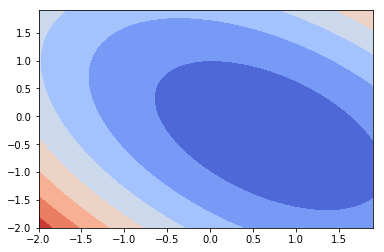

In [12]:
h = plt.contourf(x, y, j_mse, cmap=cm.coolwarm)

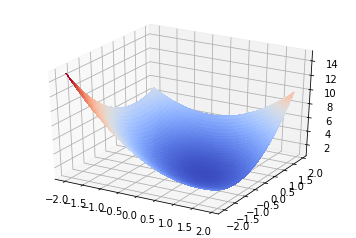

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, j_mse, cmap=cm.coolwarm, linewidth=0, antialiased=False)